In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import Data

In [3]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_index.csv")

In [4]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

## Z-Score Standardization

In [5]:
# Assuming your DataFrame is named df
features_columns = ['volatility', 'price_change', 'volume_change']

# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features


In [6]:
# Save as csv
labeled_index.to_csv('../data/labeled_data/' + f"quarterly_labeled_index_standardized.csv", index=False)
print(f"Saved quarterly_labeled_index_standardized.csv")

Saved quarterly_labeled_index_standardized.csv


## Build the model

In [116]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Hyperparameter Tuning
    param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'sag', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=2)
    try:
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)

    # Train the model
    model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    #joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1

[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=1

[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ................C=1

[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=

[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................

In [117]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_benchmark.csv", index=False)
evaluation_df
#TODO: visualize it, seperate TN, TP, FP, FN

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,MAPE,AUC-ROC,False Positive Rate,True Positive Rate,volatility_importance,price_change_importance,volume_change_importance
0,1998-03-31,2002-06-30,2002-09-30,2005-12-31,"[[108, 19], [3, 10]]",0.344828,0.769231,0.476190,0.842857,0.396412,inf,0.929134,"[0.0, 0.0, 0.015748031496062992, 0.01574803149...","[0.0, 0.07692307692307693, 0.07692307692307693...",0.513105,-0.428043,-0.191523
1,1998-03-31,2005-12-31,2006-03-31,2009-06-30,"[[80, 30], [1, 29]]",0.491525,0.966667,0.651685,0.778571,0.470562,inf,0.880606,"[0.0, 0.0, 0.01818181818181818, 0.018181818181...","[0.0, 0.03333333333333333, 0.03333333333333333...",0.555676,-0.859788,-0.326360
2,1998-03-31,2009-06-30,2009-09-30,2012-12-31,"[[108, 24], [1, 7]]",0.225806,0.875000,0.358974,0.821429,0.422577,inf,0.943182,"[0.0, 0.0, 0.0, 0.007575757575757576, 0.007575...","[0.0, 0.125, 0.25, 0.25, 0.375, 0.375, 0.625, ...",0.101386,-0.608720,-0.097052
3,1998-03-31,2012-12-31,2013-03-31,2016-06-30,"[[113, 16], [4, 7]]",0.304348,0.636364,0.411765,0.857143,0.377964,inf,0.744891,"[0.0, 0.0, 0.0, 0.023255813953488372, 0.023255...","[0.0, 0.09090909090909091, 0.18181818181818182...",0.040909,-1.256903,-0.376252
4,1998-03-31,2016-06-30,2016-09-30,2019-12-31,"[[124, 15], [0, 1]]",0.062500,1.000000,0.117647,0.892857,0.327327,inf,1.000000,"[0.0, 0.0, 1.0]","[0.0, 1.0, 1.0]",0.017201,-0.776571,-0.049862


## Shap Values
- color: how higher and lower values of the feature will affect the result
- X-axis: impact on output

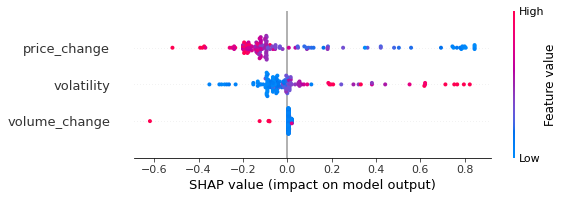

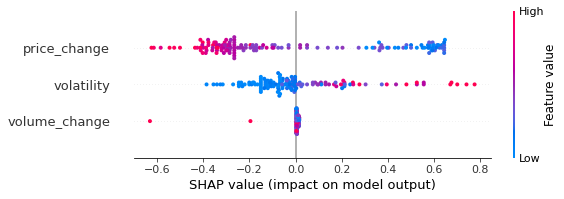

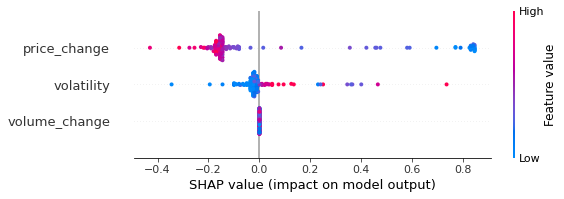

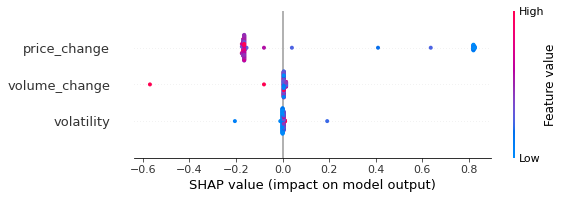

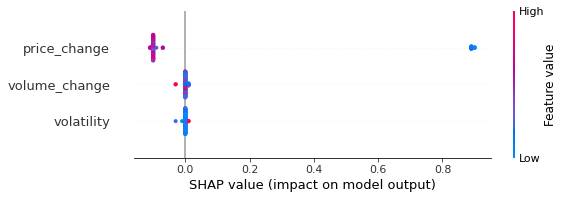

AttributeError: module 'shap.plots' has no attribute 'gridplot'

In [60]:
for shap_values in shap_values_list:
    shap.plots.beeswarm(shap_values)

## Feature Importance

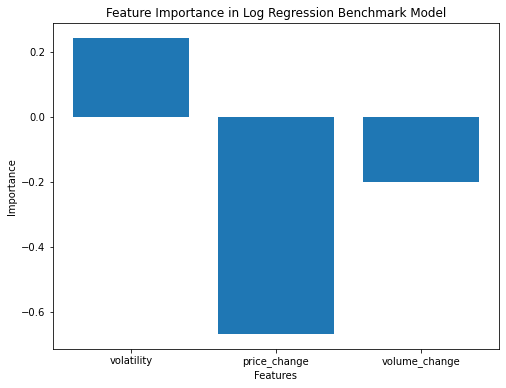

In [8]:
model_name = "Log Regression Benchmark"
plot_feature_importances(evaluation_df, model_name)

## AUC-ROC

In [10]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8995625010404356


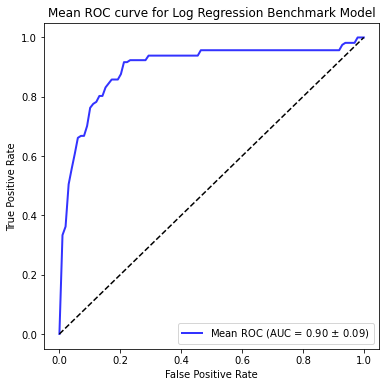

In [9]:
plot_roc_curve(evaluation_df, model_name)